In [1]:
%run variable_weights.py

# Warp
# Origin date: Tue, 7 Jan 2020 09:31:24 -0700
# Local date: Tue, 7 Jan 2020 09:31:24 -0700
# Commit hash: 4ebb54f
# /home/vagrant/.pyenv/versions/py3/lib/python3.7/site-packages/warp/warp.py
# /home/vagrant/.pyenv/versions/py3/lib/python3.7/site-packages/warp/warpC.cpython-37m-x86_64-linux-gnu.so
# Tue May  5 22:19:36 2020
# import warp time 0.09468960762023926 seconds
# For more help, type warphelp()
 ***  particle simulation package W3D generating
 ---  Resetting lattice array sizes
 ---  Allocating space for particles
 ---  Loading particles
 ---  Setting charge density
 ---  done
 ---  Allocating Win_Moments
 ---  Allocating Z_Moments
 ---  Allocating Lab_Moments


In [2]:
import matplotlib.pyplot as plt

# Setting particle weights
There are a lot of ways to initialize and adjust properties like particle weight in Warp. The preferred method for setup is normally through the `Species` Class. However, `Species` is just a convenience class that is really handling a lot of variable and array initialization for you that is being stored in Warp's `top` object.

In the first example we start by setting the weight for all particles uniformly with our `beam` instance of `Species`
> beam.sw = 100.0

We can check this by calling `beam.getweights()` (not sure if this works before `generate()` is called - which handles a lot of general initialization - many things may not work if `generate()` isn't called)

In [3]:
beam.getweights()

array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100.])

This is really just pulling from top. All individual particle data is stored (by Species index if there are multiple Species) in top.pgroup. Most attributes of top.pgroup are always created if the Species has particles (e.g. `top.pgroup.xp` stores the x positions of a Species - see ParticleGroup in top.v for a full list).
It is important to note that the array we care about `top.pgroup.pid` is only initialized under certain conditions. If we set `lvariableweights=True` and in our example this initialization will have been taken care of.

Note:

`top.pgroup.pid` can store many optional quantities (see ParticleGroup in top.v for a full list). To know if a quantity is being recorded and its index you can use the corresponding name from `top`. (Fortran indexing is used)

In [4]:
print(wp.top.wpid)

1


So our particle weights are

In [5]:
wp.top.pgroup.pid[:wp.top.nplive, wp.top.wpid - 1]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.])

Species weight is what we initialized with (`beam.sw`) it is stored in another array that is indexed based on species number. We only have one species though. We can see now that when we call `beam.getweights()` we are actually getting 
> wp.top.pgroup.sw * wp.top.pgroup.pid[:wp.top.nplive, wp.top.wpid - 1]

In [6]:
wp.top.pgroup.sw

array([100.])

# Changing particle weights

Looking at charge deposition on the grid provides an easy way to check what is happening with particle weights

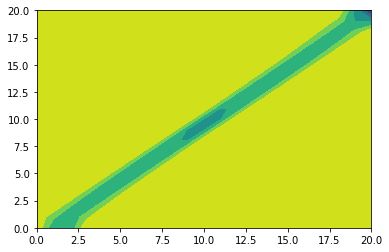

In [7]:
plt.figure()
plt.contourf(solverE.getrhop())
plt.show()

There are builtin selection functions in Warp to filter based on most particle attributes but we'll use NumPy functions for convenience in this example

In [8]:
mask = np.where(beam.getx() < 0)[0]

In [9]:
wp.top.pgroup.pid[mask, wp.top.wpid - 1] = 42.

Check the result in the array

In [10]:
wp.top.pgroup.pid[:wp.top.nplive, wp.top.wpid - 1]

array([42., 42., 42., 42., 42., 42., 42., 42., 42.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.])

#### Take one step to update deposition

In [11]:
wp.step(1)

 ***  particle simulation package W3D running


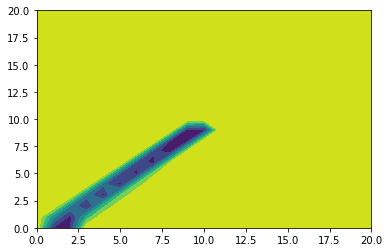

In [12]:
plt.figure()
plt.contourf(solverE.getrhop())
plt.show()

# Updating automatically

Can use `installafterstep` function that can be used to call functions at the end of the PIC-cycle step (there are corresponding functions to call before/after most individual portions of the cycle).

Here we just use a trivial example to reset the weights

In [13]:
def fix_weights():
    wp.top.pgroup.pid[:, wp.top.wpid - 1] = 42.
wp.installafterstep(fix_weights)

In [14]:
wp.step(2)
# Apparently you have to take 2 steps here to see the expected uniform density. 
# Not sure if this is expected or something strange happening with the function call

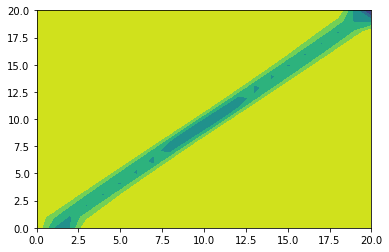

In [15]:
plt.figure()
plt.contourf(solverE.getrhop())
plt.show()

# !!!WARNING!!!
One important thing to note. If you are executing Warp in parallel then each rank has its own copy of top. Python level calls (e.g. beam.getweights()) can perform the necessary MPI communication to return all particle data to the head rank. If manipulation is being performed directly with `top` then obviously the user is responsible for making sure they handle the MPI communication as desired.